**Due: 4 PM on Wednesday, 24 Mar 2016**

Instructions
-----

Write code to solve all problems. The grading rubric includes the following criteria:

- Correctness
- Readability
- Efficiency

Please do not copy answers found on the web or elsewhere as it will not benefit your learning. Searching the web for general references etc. is OK. Some discussion with friends is fine too - but again, do not just copy their answer. 

**Honor Code: By submitting this assignment, you certify that this is your original work.**

**Exercise 1 (50 points)**

#### Gibbs sampler example from [Robert and Casella, 10.17](http://www.springer.com/statistics/statistical+theory+and+methods/book/978-0-387-21239-5)

Suppose we have data of the number of failures ($y_i$) for each of 10 pumps in a nuclear plant. We also have the times ($t_i$) at which each pump was observed. We want to model the number of failures with a Poisson likelihood, where the expected number of failure $\lambda_i$ differs for each pump. Since the time which we observed each pump is different, we need to scale each $\lambda_i$ by its observed time $t_i$. To be explicit, we assume that $y_i$ has a Poisson distribution with rate $\mu_i = \lambda_i t_i$.

The likelihood $f$ is 
$$
\prod_{i=1}^{10} \text{Poisson}(\mu_i t_i)
$$

We let the prior $g$ for $\lambda$ be 

$$
\lambda \sim \text{Gamma}(\alpha_\mu, \beta_\mu)
$$

and let the hyperprior $h$ for $\alpha$ to be 

$$
\alpha \sim \text{Gamma}(\alpha_\alpha, \beta_\alpha)
$$

with $\alpha_\alpha = 1.8$ and $\beta_\alpha = 1.0$.

and let the hyperprior $h$ for $\beta$ to be 

$$
\beta \sim \text{Gamma}(\alpha_\beta, \beta_\beta)
$$

with $\alpha_\beta = 1.0$ and $\beta_\beta = 10.0$.

There are 12 unknown parameters (10 $\lambda$s, $\alpha$ and $\beta$) in this hierarchical model. Do th following using `pymc3` and some plotting package.

- Wrtie the model and run for 10,000 iterations using the No U-Turn Sampler (30 points)
- plot the traces and distributions of the last 10% for $\lambda_i$, $\alpha$ and $\beta$ (there should be 12 sets of plots) (10 points)
- Gnnerate 1,000 samples of the number of failures $y_i$ from the prior distribution and plot the histogram or density. That is, for each of the 10 pumps, we want to see the distribtuion of 1,000 draws of the number of failures (5 points).
- Generate 1,000 posterior predictive samples of the number of failures $y_i$ and plot the histogram or density. This is similar to the previous question but using draws from the posterior  (5 points)

Use the following data
```python
y = np.array([5, 1, 5, 14, 3, 19, 1, 1, 4, 22])
t = np.array([94.32, 15.72, 62.88, 125.76, 5.24, 31.44, 1.05, 1.05, 2.10, 10.48])
```

In [1]:
import pymc3 as pm

### Data set

In [2]:
y = np.array([5, 1, 5, 14, 3, 19, 1, 1, 4, 22])
t = np.array([94.32, 15.72, 62.88, 125.76, 5.24, 31.44, 1.05, 1.05, 2.10, 10.48])

### Model

In [3]:
niter = 10000
with pm.Model() as nuclear:
    alpha = pm.Gamma('alpha', alpha=1.8, beta=1.0)
    beta = pm.Gamma('beta', alpha=1.0, beta=10.0)
    lam = pm.Gamma('lambda', alpha=alpha, beta=beta, shape=len(y))
    y_obs = pm.Poisson('y_obs', mu=lam*t, observed=y)

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)

    trace = pm.sample(niter, step=step, start=start)

Applied log-transform to alpha and added transformed alpha_log to model.
Applied log-transform to beta and added transformed beta_log to model.
Applied log-transform to lambda and added transformed lambda_log to model.
 [-----------------100%-----------------] 10000 of 10000 complete in 17.8 sec

### Posterior

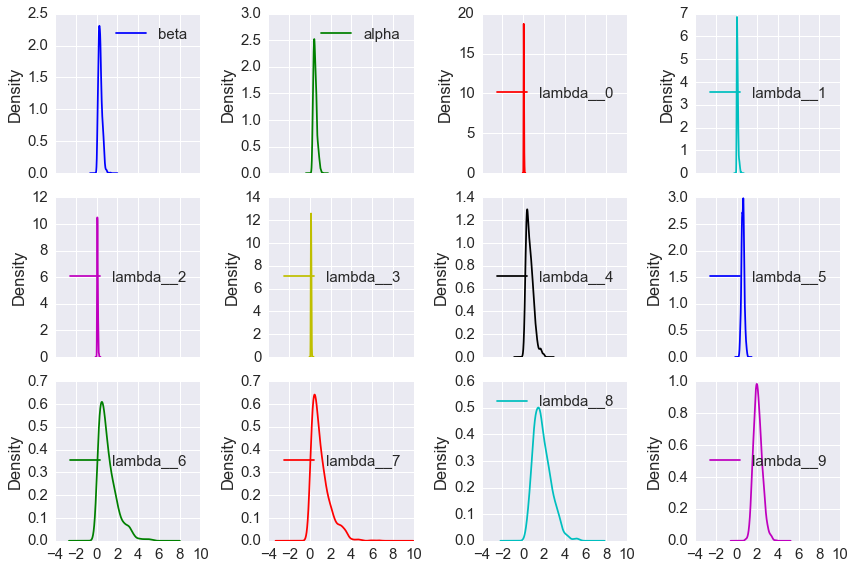

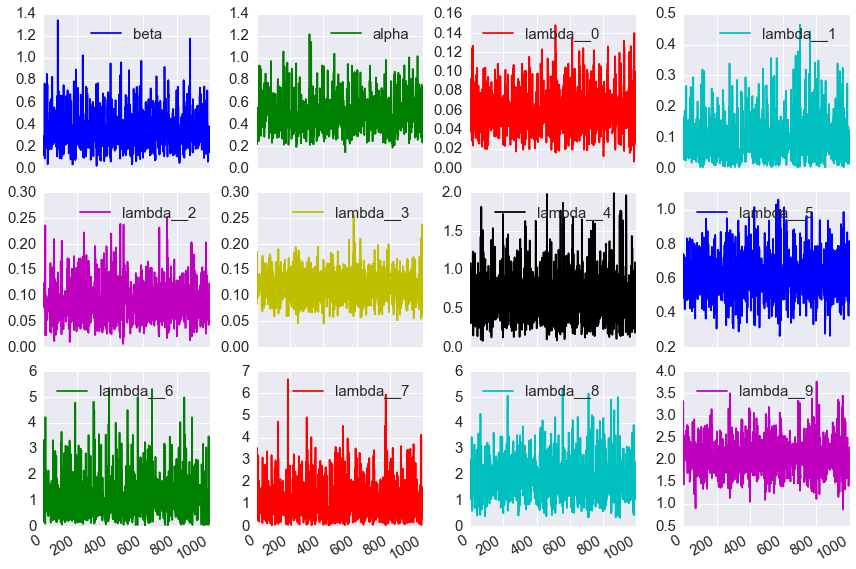

In [4]:
df = pm.trace_to_dataframe(trace[int(0.9*niter):])
cols = df.columns[~df.columns.str.contains('log')]
df[cols].plot(kind='kde', subplots=True, layout=(3,4), figsize=(12,8), )
plt.tight_layout()
df[cols].plot(kind='line', subplots=True, layout=(3,4), figsize=(12,8))
plt.tight_layout()
pass

### Posterior predictive samples

In [5]:
with nuclear:
    y_obs = pm.sample_ppc(trace, vars=[y_obs], samples=1000)['y_obs']

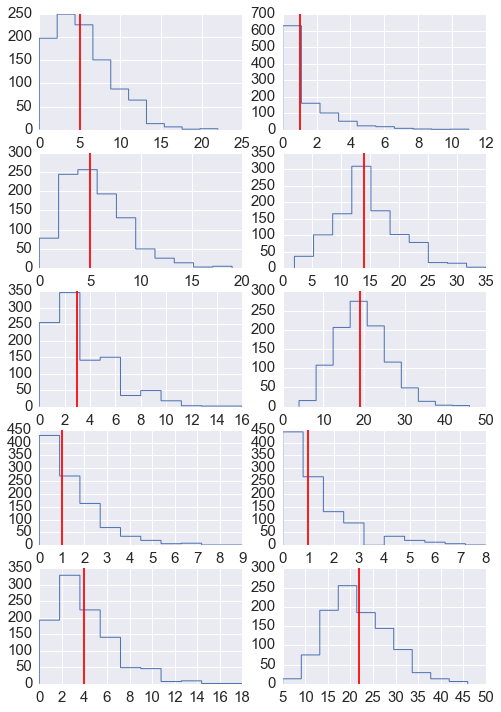

In [6]:
nrows = 5
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(8, 12))
for i in range(nrows):
    for j in range(ncols):
        axes[i,j].hist(y_obs[:, i*ncols+j], histtype='step', linewidth=1)
        axes[i,j].axvline(y[i*ncols+j], color='red')

### Prior

### Model for prior

In [7]:
niter = 10000
with pm.Model() as nuclear_prior:
    alpha = pm.Gamma('alpha', alpha=1.8, beta=1.0)
    beta = pm.Gamma('beta', alpha=1.0, beta=10.0)
    mu = pm.Gamma('mu', alpha=alpha, beta=beta, shape=len(y))
    y_obs = pm.Poisson('y_obs', mu=mu*t, shape=len(y))

    start = pm.find_MAP()
    step = pm.Metropolis()

    prior = pm.sample(niter, step=step, start=start)

Applied log-transform to alpha and added transformed alpha_log to model.
Applied log-transform to beta and added transformed beta_log to model.
Applied log-transform to mu and added transformed mu_log to model.
 [-----------------100%-----------------] 10000 of 10000 complete in 5.8 sec

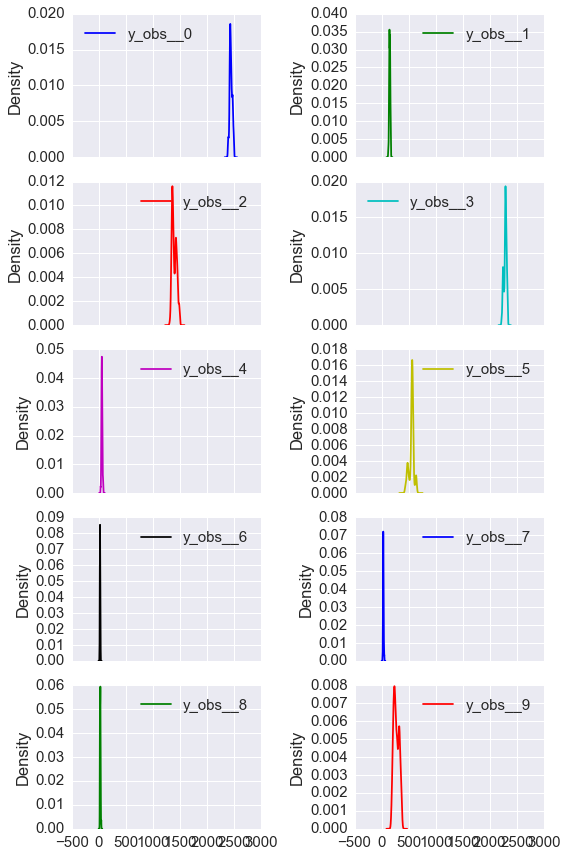

In [8]:
df = pm.trace_to_dataframe(prior[int(0.9*niter):])
cols = df.columns[df.columns.str.startswith('y_obs')]
df[cols].plot(kind='kde', subplots=True, layout=(5, 2), figsize=(8,12))
plt.tight_layout()

**Exercise 2 (50 points)**

Repeat Exercise 1 using `pystan`.

In [9]:
import pystan

In [10]:
y = np.array([5, 1, 5, 14, 3, 19, 1, 1, 4, 22])
t = np.array([94.32, 15.72, 62.88, 125.76, 5.24, 31.44, 1.05, 1.05, 2.10, 10.48])
n = len(y)

In [11]:
nuclear_code = """
data {
    int<lower=0> n;
    int<lower=0> y[n];
    real<lower=0> t[n];
}
transformed data {}
parameters {
    real<lower=0> alpha;
    real<lower=0> beta;
    real<lower=0> lambda[n];
    real<lower=0> mu[n];
}
transformed parameters {}
model {
    alpha ~ gamma(1.8, 1.0);
    beta ~ gamma(1.0, 0.1);
    for (i in 1:n) {
        lambda[i] ~ gamma(alpha, beta);
    }
    for (i in 1:n) {
        y[i] ~ poisson(lambda[i] * t[i]);
    }
}
generated quantities {
    int y_pred[n];
    for (i in 1:n) {
        y_pred[i] <- poisson_rng(lambda[i] * t[i]);
    }
}
"""

nuclear_dat = {
             'n': n,
             'y': y,
             't': t,
            }

fit = pystan.stan(model_code=nuclear_code, data=nuclear_dat, 
                  iter=10000, warmup=9000, chains=1)

In [12]:
alpha = fit.extract('alpha')['alpha']
beta = fit.extract('beta')['beta']

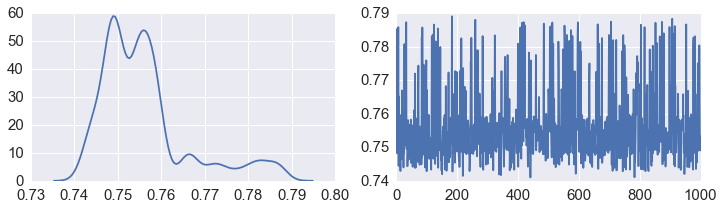

In [13]:
fig, axes = plt.subplots(1,2,figsize=(12,3))
sns.kdeplot(alpha, ax=axes[0])
axes[1].plot(alpha)
pass

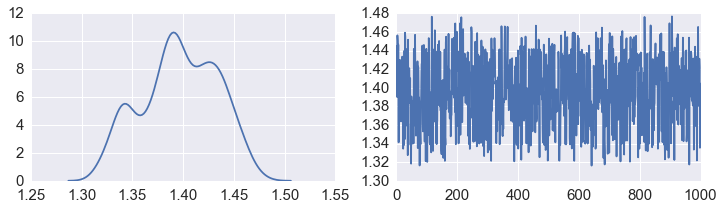

In [14]:
fig, axes = plt.subplots(1,2,figsize=(12,3))
sns.kdeplot(beta, ax=axes[0])
axes[1].plot(beta)
pass

In [15]:
lam = fit.extract('lambda')['lambda']

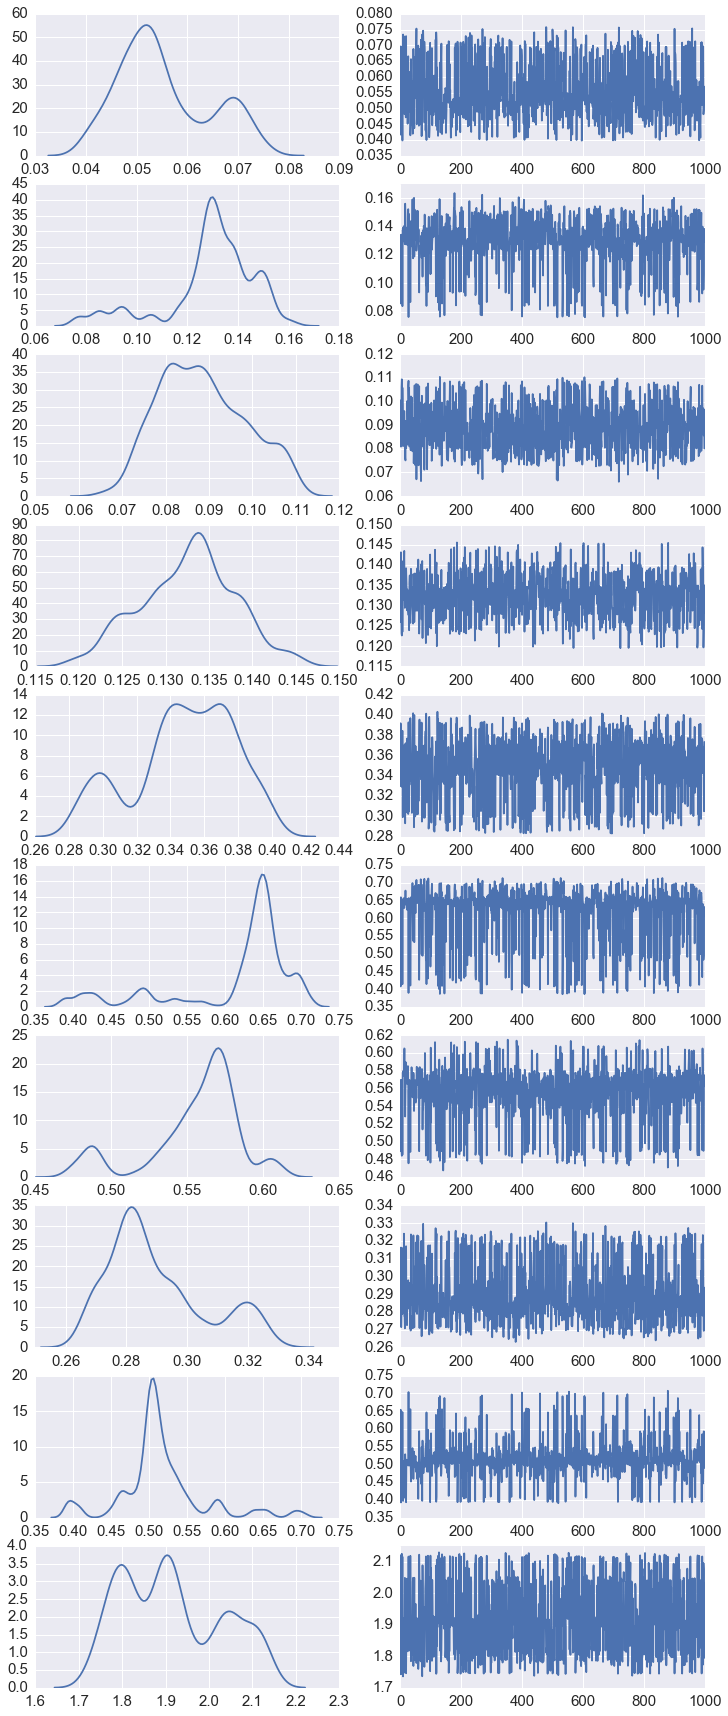

In [16]:
fig, axes = plt.subplots(10,2,figsize=(12,30))
for row in range(10):
    for col in range(2):
        if col == 0:
            sns.kdeplot(lam[:, row], ax=axes[row, col])
        else:
            axes[row, col].plot(lam[:, row])

### Posterior Predictive samples

In [17]:
y_pred = fit.extract('y_pred')['y_pred']
y_pred.shape

(1000, 10)

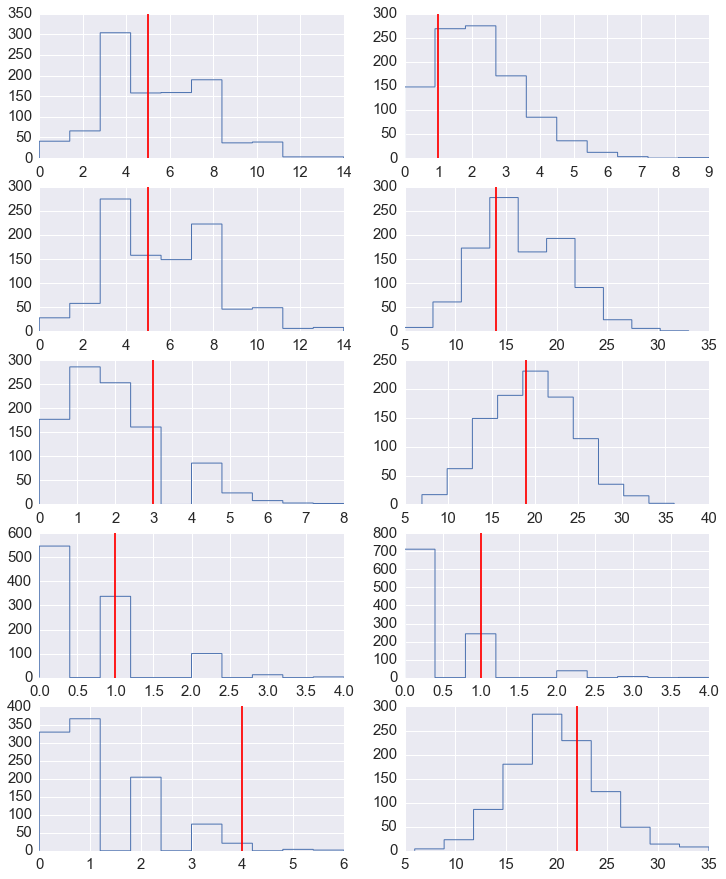

In [18]:
fig, axes = plt.subplots(5,2,figsize=(12,15))
for row in range(5):
    for col in range(2):
        axes[row,col].hist(y_pred[:, row*2+col], histtype='step', linewidth=1)
        axes[row,col].axvline(y[row*2+col], color='red')

### Prior

In [19]:
nuclear_prior_code = """
data {
    int<lower=0> n;
    real<lower=0> t[n];
}
transformed data {}
parameters {
    real<lower=0> alpha;
    real<lower=0> beta;
    real<lower=0> lambda[n];
    real<lower=0> mu[n];
}
transformed parameters {}
model {
    alpha ~ gamma(1.8, 1.0);
    beta ~ gamma(1.0, 0.1);
    for (i in 1:n) {
        lambda[i] ~ gamma(alpha, beta);
    }

}
generated quantities {
    int<lower=0> y[n];
    for (i in 1:n) {
        y[i] <- poisson_rng(lambda[i] * t[i]);
    }
}
"""

nuclear_prior_dat = {
             'n': n,
             't': t,
            }

fit_prior = pystan.stan(model_code=nuclear_prior_code, data=nuclear_prior_dat, 
                        iter=10000, warmup=9000, chains=1)

In [20]:
y_prior = fit_prior.extract('y')['y']
y_prior.shape

(1000, 10)

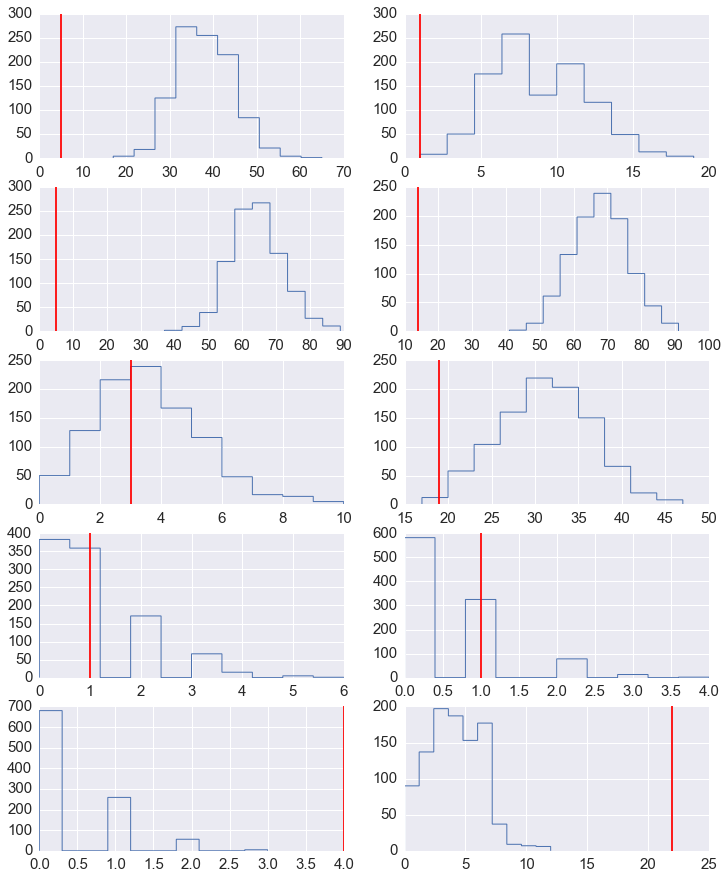

In [21]:
fig, axes = plt.subplots(5,2,figsize=(12,15))
for row in range(5):
    for col in range(2):
        axes[row,col].hist(y_prior[:, row*2+col], histtype='step', linewidth=1)
        axes[row,col].axvline(y[row*2+col], color='red')